<a href="https://colab.research.google.com/github/davidfague/Model_Reduction_Methods/blob/main/Passive_Properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Reduction preserves passive and active properties
##passive properties:

membrane time constant and input resistance of the soma using a somatic negative current injection.


## active properties:

F/I curve of soma with somatic current injection

#### Download modules from Github

In [1]:
!pip install neuron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 28.5 MB/s eta 0:00:00


In [2]:
!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!git clone https://github.com/davidfague/Model_Reduction_Methods.git

Cloning into 'Model_Reduction_Methods'...
remote: Enumerating objects: 440, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 440 (delta 72), reused 0 (delta 0), pack-reused 314
Receiving objects: 100% (440/440), 3.03 MiB | 10.47 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [4]:
%cd Model_Reduction_Methods/

#import reduction and expansion functions
from test_neuron_reduce.subtree_reductor_func import subtree_reductor
from cable_expander_func import cable_expander

#import recording functions
from stylized_module.recorder import Recorder

#import analysis functions
from utils import make_seg_df,generate_stylized_geometry,make_reduced_seg_df,plot_morphology,check_connectivity,generate_reduced_cell_seg_coords, create_seg_var_report

import pandas as pd

/content/Model_Reduction_Methods


In [5]:
%cd expand_example

/content/Model_Reduction_Methods/expand_example


In [6]:
# compile the mod files
!nrnivmodl mod

/content/Model_Reduction_Methods/expand_example
Mod files: "mod/mod/CaDynamics_E2.mod" "mod/mod/Ca_HVA.mod" "mod/mod/Ca_LVAst.mod" "mod/mod/epsp.mod" "mod/mod/Ih.mod" "mod/mod/Im.mod" "mod/mod/K_Pst.mod" "mod/mod/K_Tst.mod" "mod/mod/Nap_Et2.mod" "mod/mod/NaTa_t.mod" "mod/mod/NaTs2_t.mod" "mod/mod/SK_E2.mod" "mod/mod/SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../mod/CaDynamics_E2.mod
 -> NMODL ../mod/Ca_HVA.mod
 -> NMODL ../mod/Ca_LVAst.mod
Translating CaDynamics_E2.mod into /content/Model_Reduction_Methods/expand_example/x86_64/CaDynamics_E2.c
Thread Safe
Translating Ca_LVAst.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_LVAst.c
Translating Ca_HVA.mod into /content/Model_Reduction_Methods/expand_example/x86_64/Ca_HVA.c
Thread Safe
 -> NMODL ../mod/epsp.mod
 -> NMODL ../mod/Ih.mod
Thread Safe
 -> NMODL ../mod/Im.mod
Translating epsp.mod into /content/Model_Reduction_Methods/expand_example/x86_64/epsp.c
Translating Ih

## Setup smiulation parameters

In [7]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from neuron import h
from scipy import signal
from IPython.display import display, clear_output
from ipywidgets import interactive_output, HBox, VBox, Label, Layout

from __future__ import division
from neuron import gui,h
import numpy as np
import time
import matplotlib.pyplot as plt

%matplotlib inline


h.load_file('stdrun.hoc')
# h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)  # choose the set of mechanisms
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')


1.0

### Create a cell with reduced morphology

In [8]:
%ls

cell1.asc  example_expand.py  L5PCtemplate.hoc  x86_64/
Cell.hoc   L5PCbiophys3.hoc   mod/


In [9]:
from abc import ABC, abstractmethod
class PointCurrent(ABC):
    """A module for current point process"""

    def __init__(self, cell, sec_index, loc=0.5):
        """
        cell: target cell object
        sec_index: index of the target section in the section list
        loc: location on a section, between [0,1]
        """
        self.cell = cell
        self.sec_index = sec_index
        self.loc = loc
        self.pp_obj = None  # point process object
        self.rec_vec = None  # vector for recording

    @abstractmethod
    def setup(self, record: bool = None) -> None:
        pass

    def setup_recorder(self):
        size = [round(h.tstop / h.dt) + 1] if hasattr(h, 'tstop') else []
        self.rec_vec = h.Vector(*size).record(self.pp_obj._ref_i)

    def get_section(self) -> h.Section:
        return self.cell.all[self.sec_index]

    def get_segment(self):
        return self.pp_obj.get_segment()

    def get_segment_id(self) -> int:
        """Get the index of the injection target segment in the segment list"""
        iseg = int(self.get_segment().x * self.get_section().nseg)
        return self.cell.sec_id_in_seg[self.sec_index] + iseg


In [10]:
from __future__ import annotations
from typing import List, Optional, Any, TYPE_CHECKING
class CurrentInjection(PointCurrent):
    """A module for current injection"""

    def __init__(self, cell, sec_index: int, loc: float = 0.5,
                 pulse: bool = True, current: Optional[np.ndarray, List[int]] = None,
                 dt: Optional[np.ndarray] = None, record: bool = False, **pulse_param: Any) -> None:
        """
        cell: target cell object
        sec_index: index of the target section in the section list
        loc: location on a section, between [0,1]
        pulse: If True, use pulse injection with keyword arguments in 'pulse_param'
               If False, use waveform resources in vector 'current' as injection
        Dt: current vector time step size
        record: If True, enable recording current injection history
        """
        super().__init__(cell, sec_index, loc)
        self.pp_obj = h.IClamp(self.get_section()(self.loc))
        self.inj_vec = None
        if pulse:
            self.setup_pulse(**pulse_param)
        else:
            if current is None:
                current = [0]
            self.setup_current(current, dt)
        self.setup(record)

    def setup(self, record: bool = False) -> None:
        if record:
            self.setup_recorder()

    def setup_pulse(self, **pulse_param: Any) -> None:
        """Set IClamp attributes. Argument keyword: attribute name, arugment value: attribute value"""
        for param, value in pulse_param.items():
            setattr(self.pp_obj, param, value)

    def setup_current(self, current: Optional[np.ndarray, List[int]], dt: Optional[np.ndarray]) -> None:
        """Set current injection with the waveform in vector 'current'"""
        ccl = self.pp_obj
        ccl.dur = 0
        ccl.dur = h.tstop if hasattr(h, 'tstop') else 1e30
        if dt is None:
            dt = h.dt
        self.inj_vec = h.Vector()
        self.inj_vec.from_python(current)
        self.inj_vec.append(0)
        self.inj_vec.play(ccl._ref_amp, dt)

In [11]:
class Synapse(PointCurrent):
    def __init__(self, cell, stim: h.NetStim, sec_index: int,
                  syn_type: str = 'Exp2Syn', gmax: float = 0.01, loc: float = 0.5,
                  record: bool = False):
        super().__init__(cell, sec_index, loc)
        self.stim = stim
        self.gmax = gmax
        self.__synapse_type(syn_type)
        self.setup(record)

    # PRIVATE METHODS
    def __synapse_type(self, syn_type):
        if syn_type == 'AlphaSynapse1':
            # Reversal potential (mV); Synapse time constant (ms)
            self.syn_params = {'e': 0., 'tau': 2.0}
            # Variable name of maximum conductance (uS)
            self.gmax_var = 'gmax'
        elif syn_type == 'Exp2Syn':
            self.syn_params = {'e': 0., 'tau1': 1.0, 'tau2': 3.0}
            self.gmax_var = '_nc_weight'
        else:
            raise ValueError("Synpase type not defined.")
        self.syn_type = syn_type
        self.pp_obj = getattr(h, syn_type)(self.get_section()(self.loc))

    def __setup_synapse(self):
        self.syn = self.pp_obj
        self.nc = h.NetCon(self.stim, self.syn, 1, 0, 1)
        for key, value in self.syn_params.items():
            setattr(self.syn, key, value)
        self.set_gmax()

    # PUBLIC METHODS
    def setup(self, record: bool = False):
        self.__setup_synapse()
        if record:
            self.setup_recorder()
    
    def set_gmax(self, gmax: float = None):
        if gmax is not None:
            self.gmax = gmax
        if self.gmax_var == '_nc_weight':
            self.nc.weight[0] = self.gmax
        else:
            setattr(self.syn, self.gmax_var, self.gmax)

In [12]:
from typing import Optional, Union, List
import math
class cell_model():
  '''expanded cell model class for ECP calculation
  takes cell model and does bookkeeping for analysis functions
  '''
  def __init__(self,model,gen_3d=True,spike_threshold: Optional[float] = None):
    self.all=model.all
    self.soma=model.soma
    self.apic=model.apic
    self.dend=model.dend
    self.axon=model.axon
    #convert nrn section lists to python lists if applicable
    self.all=self.convert_sectionlist(sectionlist=self.all)
    self.soma=self.convert_sectionlist(sectionlist=self.soma, return_singles=True) #if sectionlist contains only one section returns just the section instead of list of sections
    self.dend=self.convert_sectionlist(sectionlist=self.dend)
    self.apic=self.convert_sectionlist(sectionlist=self.apic)
    self.axon=self.convert_sectionlist(sectionlist=self.axon)
    self.spike_threshold = spike_threshold
    self.segments=[]
    self.injection=[]
    self.synapse = []  # synapse objects
    self.sec_id_lookup = {}  # dictionary from section type id to section index
    self.sec_id_in_seg = []  # index of the first segment of each section in the segment list
    self.sec_angs = [] # list of angles that were used to branch the cell
    if gen_3d==True:
      self.generate_sec_coords()
    self.__store_segments()
    self.__set_spike_recorder()
    if self.apic[2].n3d()==2: #calc_seg_coords only works for cell with sections that only have two 3d coordinates. #detailed cell has too many 3d coordinates
      self.__calc_seg_coords()
    self.grp_ids = []
    self.generate_geometry_file()

  def __calc_seg_coords(self):
    """Calculate segment coordinates for ECP calculation"""
    p0 = np.empty((self._nseg, 3))
    p1 = np.empty((self._nseg, 3))
    p05 = np.empty((self._nseg, 3))
    r = np.empty(self._nseg)
    for isec, sec in enumerate(self.all):
        iseg = self.sec_id_in_seg[isec]
        nseg = sec.nseg
        pt0 = np.array([sec.x3d(0), sec.y3d(0), sec.z3d(0)])
        pt1 = np.array([sec.x3d(1), sec.y3d(1), sec.z3d(1)])
        pts = np.linspace(pt0, pt1, 2 * nseg + 1)
        p0[iseg:iseg + nseg, :] = pts[:-2:2, :]
        p1[iseg:iseg + nseg, :] = pts[2::2, :]
        p05[iseg:iseg + nseg, :] = pts[1:-1:2, :]
        r[iseg:iseg + nseg] = sec.diam / 2
    self.seg_coords = {'dl': p1 - p0, 'pc': p05, 'r': r}

  def __store_segments(self):
    self.segments = []
    self.sec_id_in_seg = []
    nseg = 0
    for sec in self.all:
        self.sec_id_in_seg.append(nseg)
        nseg += sec.nseg
        for seg in sec:
            self.segments.append(seg)
            self.__store_point_processes(seg)
    self._nseg = nseg

  def __store_point_processes(self,seg):
    for pp in seg.point_processes():
        self.injection.append(pp)

  def __set_spike_recorder(self, threshold: Optional = None):
      if threshold is not None:
          self.spike_threshold = threshold
      if self.spike_threshold is None:
          self.spikes = None
      else:
          vec = h.Vector()
          nc = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
          nc.threshold = self.spike_threshold
          nc.record(vec)
          self.spikes = vec

  def add_injection(self, sec_index, **kwargs):
        """Add current injection to a section by its index"""
        self.injection.append(CurrentInjection(self, sec_index, **kwargs))

  def add_synapse(self, stim: h.NetStim, sec_index: int, **kwargs):
        """Add synapse to a section by its index"""
        self.synapse.append(Synapse(self, stim, sec_index, **kwargs))

  def generate_sec_coords(self):
      '''
      Note: need to improve branching so that it is random direction in a quadrant of a sphere rather than x-y plane
      takes a cell that has no n3d() coordinates and gives new coordinates
      by choosing an arbitrary direction for the subtree to move
      '''
      parent_sections=[] #list for already seen parent_sections
      section_obj_list= self.all
      # print(section_obj_list)
      axial=False
      for sec in section_obj_list:
        sec_length=sec.L
        if sec is self.soma:
          self.sec_angs.append(0)
          # pt0 = [0., -1 * sec.diam, 0.] #does not seem to preserve soma shape , but need to make sure children begin at correct 3d coordinate.
          # pt1 = [0., 0., 0.]
          # sec.pt3dclear()
          # sec.pt3dadd(*pt0, sec.diam)
          # sec.pt3dadd(*pt1, sec.diam)
          print('Changing soma nseg from',sec.nseg,'to 1')
          sec.nseg = 1
        else:
          if sec.parentseg() is not None:
            psec=sec.parentseg().sec
            if psec==self.soma:
              nbranch=1
            else:
              nbranch = len(psec.children())
          else:
            psec=None # may need to provide more implementation in the case of no 3d coords and no parent section.
            nbranch=1
          rot = 2 * math.pi/nbranch
          i=parent_sections.count(psec)
          parent_sections.append(psec)
          length=sec.L
          diameter=sec.diam
          fullsecname = sec.name()
          # print(fullsecname)
          sec_type = fullsecname.split(".")[1][:4]
          # print(sec_type)
          if sec_type == "apic":
            ang=np.random.normal(scale=0.1,loc=1.570796327) # somewhat arbitrary angle in the Q1/Q2 of xy-plane # may adjust as needed
          elif sec_type=="dend":
            ang=-np.random.uniform(low=0,high=np.pi) # arbitrary angle in the Q3/Q4 of xy=plane # may adjust as needed 
          elif sec_type=="axon":
            ang=-np.random.uniform(low=0,high=np.pi) # arbitrary angle in the Q3/Q4 of xy=plane # may adjust as needed 
          else:
            print(sec,sec_type,' is not apic, dend or axon')
            ang=0
          if axial == True:
            x = 0
            y = length*((ang>=0)*2-1)
          else:
            x = length * math.cos(ang)
            y = length * math.sin(ang)
          self.sec_angs.append(ang)
          #find starting position
          pt0 = [psec.x3d(1), psec.y3d(1), psec.z3d(1)]
          pt1 = [0., 0., 0.]
          pt1[1] = pt0[1] + y
          pt1[0] = pt0[0] + x * math.cos(i * rot)
          pt1[2] = pt0[2] + x * math.sin(i * rot)
          sec.pt3dclear()
          sec.pt3dadd(*pt0, sec.diam)
          sec.pt3dadd(*pt1, sec.diam)
        if int(sec.L) != int(sec_length):
          print('Error: generation of 3D coordinates resulted in change of section length for',sec,'from',sec_length,'to',sec.L)

  def generate_geometry_file(self):
    '''
    generates geometry file specifying name, pid, ang, radius, length, type
    work in progress
    '''
    df = pd.DataFrame()
    ids=[]
    names=[]
    types=[]
    pids=[]
    axials=[]
    nbranchs=[]
    Ls=[]
    Rs=[]
    # angs=self.angs
    for sec in self.all:
      # print(dir(sec))
      name=sec.name()
      # print(name)
      names.append(name)
      ids.append(names.index(name))
      _,sec_type_withinteger=name.split('.')
      sec_type,_=sec_type_withinteger.split('[')
      types.append(sec_type)
      pseg = sec.parentseg()
      if pseg == None:
        pids.append(None)
      else:
        psec=pseg.sec
        px3d=psec.x3d
        pids.append(names.index(psec.name()))
      # axials.append('TRUE')
      # nbranchs.append(1)
      Ls.append(sec.L)
      # print(dir(sec))
      Rs.append(sec.diam/2)
    df['id']=ids
    df['name']=names
    df['pid']=pids
    df['type']=types
    df['L']=Ls
    df['R']=Rs
    # df['axials']=axials # may need to fix
    # df['nbranch']=nbranchs # may need to fix
    self.geometry=df

  def convert_sectionlist(self,sectionlist,return_singles=False):
    '''
    convert nrn sectionlist objects to python list
    return_singles set to true will return section instead of [section] for lists with only one section
    '''
    new_sectionlist=[]
    if str(type(sectionlist)) == "<class 'hoc.HocObject'>":
      for sec in sectionlist:
        new_sectionlist.append(sec)
    else:
      new_sectionlist=sectionlist
    if return_singles==True:
      if str(type(new_sectionlist))!="<class 'nrn.Section'>":
        if len(new_sectionlist)==1:
          new_sectionlist=new_sectionlist[0]
    return new_sectionlist

In [13]:

# # Load biophysical parameters from a json file
# filepath = os.path.join(paths.RESOURCES_ROOT, 'biophys_parameters/ReducedOrderL5_passive.json')
# with open(filepath) as f:
#     biophys_param = json.load(f)
# for genome in biophys_param['genome']:
#     if genome['value'] != "": genome['value'] = float(genome['value'])

h.load_file('L5PCbiophys3.hoc')

# # Load morphology parameters from a csv file
# geometry = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
h.load_file("import3d.hoc")


# Create a cell object
# cell = ReducedOrderL5CellPassiveDendrite(geometry=geometry, full_biophys=biophys_param)
h.load_file('L5PCtemplate.hoc')
complex_cell = h.L5PCtemplate('cell1.asc')
h.celsius = 37
h.v_init = complex_cell.soma[0].e_pas

synapses_list=[]
netcons_list=[]

#reduce dendritic trees to cables
reduced_cell, synapses_list, netcons_list, txt = subtree_reductor(complex_cell, synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

# print('reduced cell n3d')
# for sec in reduced_cell.dend:
#   print(sec,sec.n3d())

#expand cables to idealized dendritic trees
sections_to_expand = [reduced_cell.hoc_model.apic[0]]
furcations_x=[0.289004]
nbranches=[4]
reduced_dendritic_cell, synapses_list, netcons_list, txt = cable_expander(reduced_cell, sections_to_expand, furcations_x, nbranches, 
                                                                          synapses_list, netcons_list, reduction_frequency=0,return_seg_to_seg=True)

original_cell = h.L5PCtemplate('cell1.asc')
original_model = cell_model(original_cell,gen_3d=False,spike_threshold = 10)


# print('dendritic cell n3d')
# for sec in reduced_dendritic_cell.all:
#   print(sec, sec.n3d())

#use defined cell_model class for generating 3d coordinates, recording ECP, 'book-keeping' etc...
cell = cell_model(reduced_dendritic_cell,spike_threshold = 10)
# cell._nbranch=4


# add injections for F/I curve
delays=[250,1250,2250,3250]
durations=[750,750,750,750]
amps=[0.1,0.2,0.3,0.4]
for i in range(len(delays)):
  cell.add_injection(sec_index=0,record=True,delay=delays[i],dur=durations[i],amp=amps[i]) # Tune for proper action potential
  original_model.add_injection(sec_index=0,record=True,delay=delays[i],dur=durations[i],amp=amps[i]) # Tune for proper action potential

# #add injections for F/I curve
# cell.add_injection(sec_index=0,record=True,delay=250,dur=750,amp=0.1) # Tune for proper action potential 
# cell.add_injection(sec_index=0,record=True,delay=1250,dur=750,amp=0.2) 
# cell.add_injection(sec_index=0,record=True,delay=2250,dur=750,amp=0.3) 
# cell.add_injection(sec_index=0,record=True,delay=3250,dur=750,amp=0.4) 
#add injections for F/I curve
# original_model.add_injection(sec_index=0,record=True,delay=250,dur=750,amp=0.1) # Tune for proper action potential 
# original_model.add_injection(sec_index=0,record=True,delay=1250,dur=750,amp=0.2) 
# original_model.add_injection(sec_index=0,record=True,delay=2250,dur=750,amp=0.3) 
# original_model.add_injection(sec_index=0,record=True,delay=3250,dur=750,amp=0.4) 

#add injection for determining membrane time constant and input resistance
tau_calc_start=5000
tau_calc_start=delays[-1]+durations[-1]+1000
tau_calc_duration=850

original_model.add_injection(sec_index=0,record=True,delay=tau_calc_start,dur=tau_calc_duration,amp=-0.1) # Tune for proper action potential 
cell.add_injection(sec_index=cell.all.index(cell.soma),record=True,delay=tau_calc_start,dur=tau_calc_duration,amp=-0.1) # Tune for proper action potential

trunk_diam: 3.7176523208618155 |trunk_length: 698.0975964944687 |branch_diam: 1.475351301247016 |branch_length: 1081.9141048660235
Changing soma nseg from 1 to 1
Error: generation of 3D coordinates resulted in change of section length for L5PCtemplate[0].axon[1] from 30.0 to 29.999998978805266


In [14]:
# dir(cell)

In [15]:
import os

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install neuron==8.0.0 &> /dev/null
    os.chdir('/content')
    if not os.path.isdir('Stylized-Single-Cell-and-Extracellular-Potential'):
        !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git &> /dev/null 
    os.chdir('Stylized-Single-Cell-and-Extracellular-Potential')
    %ls

cell_inference/  Stylized_Single_Cell_Extracellular_Potential_Tutorial.ipynb


In [16]:
# tstop = 6000  # ms simulation duration
tstop = tau_calc_start+tau_calc_duration+150
dt = 0.1  # ms. does not allow change


h.tstop = tstop
h.dt = dt
h.steps_per_ms = 1/h.dt

In [17]:
from typing import Union, List, Tuple


class Recorder(object):
    """A module for recording variables"""

    def __init__(self, obj_list: Union[object, List[object], Tuple[object], np.ndarray], var_name: str = 'v') -> None:
        """
        obj_list: list of (or a single) target objects
        var_name: string of variable to be recorded
        """
        self.single = not isinstance(obj_list, (list, tuple, np.ndarray))
        self.obj_list = obj_list
        self.var_name = var_name
        self.vectors = None
        self.setup_recorder()

    def setup_recorder(self) -> None:
        size = [round(h.tstop / h.dt) + 1] if hasattr(h, 'tstop') else []
        attr_name = '_ref_' + self.var_name
        if self.single:
            self.vectors = h.Vector(*size).record(getattr(self.obj_list, attr_name))
        else:
            self.vectors = [h.Vector(*size).record(getattr(obj, attr_name)) for obj in self.obj_list]

    def as_numpy(self, copy: bool = True) -> np.ndarray:
        """
        Return a numpy 2d-array of recording, n objects-by-time
        Return a 1d-array if a single object is being recorded
        """
        if self.single:
            x = self.vectors.as_numpy()
        else:
            x = np.array([v.as_numpy() for v in self.vectors])
        if copy:
            x = x.copy()
        return x

In [18]:
nseg = len(cell.segments)
numTstep = int(tstop/dt)


# seg_list = cell.get_seg_by_id(range(nseg))

# Vrecord = []
# for i in range(len(cell.segments)):
#      Vrecord.append(cell.segments[i])

#record soma voltages
reduced_v = Recorder(cell.segments[0])
complex_v = Recorder(original_model.segments[0])

In [19]:
h.run()

0.0

In [20]:
#reduced cell input resistance and tau

# from pandas.core.internals.managers import create_block_manager_from_arrays
v_dend = reduced_v.as_numpy()
time_index_for_rest=int((tau_calc_start-300)/dt) # cell will return to rest during the pause between current injections
time_index_for_final=int((tau_calc_start+600)/dt) #cell will reach a new equilibrium voltage during the injection

v_rest = v_dend[time_index_for_rest]
print('v_rest:',v_rest)
v_final = v_dend[time_index_for_final]
print('v_final:', v_final)

#calculate time constant from v_rest and v_final
calc = v_rest -((v_rest - v_final) * 0.638)
print('v_tau:',calc)

#find where tau occurs
i = int(tau_calc_start/dt) # start time index = start_time/dt
init_i=i
while v_dend[i] > calc:
  i = i + 1

print('v at tic:',v_dend[i])


timeAtV = i*dt
print('timeAtV:', timeAtV)
print('timestep where tau occurs:', i)
time_to_reach_tau = timeAtV - tau_calc_start
time_in_seconds = time_to_reach_tau/1000

print('tau:',time_to_reach_tau,'(ms)')
print('tau:',time_in_seconds,'(s)')


deltaV = (v_rest - v_final)
deltaI = (0 - (-100))
dVdI = deltaV / (deltaI /1000)

print('Input Resistance(dVdI):',dVdI,'MOhms')

reduced_cell_input_resistance_inMOhms=dVdI
reduced_cell_tau_in_ms=time_to_reach_tau

v_rest: -75.24287955562167
v_final: -79.45404855689895
v_tau: -77.92960537843658
v at tic: -77.93849295407824
timeAtV: 5009.400000000001
timestep where tau occurs: 50094
tau: 9.400000000000546 (ms)
tau: 0.009400000000000545 (s)
Input Resistance(dVdI): 42.11169001277284 MOhms


([], [])

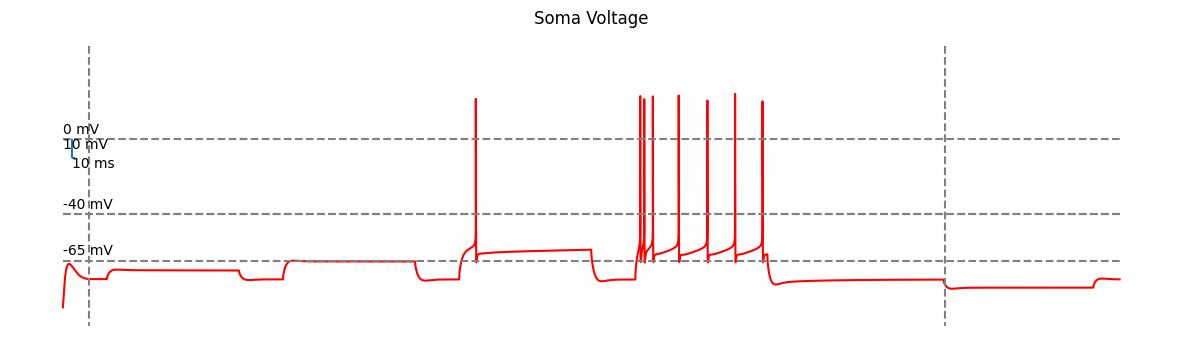

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend,color='r')
plt.hlines(-65,0,tstop, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,tstop, color = 'grey', linestyle = 'dashed')
plt.hlines(0,0,tstop, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,tstop, color = 'grey', linestyle = 'dashed')#
plt.vlines(150,50,-100, color = 'grey', linestyle = 'dashed')
plt.vlines(i/10,50,-100, color = 'grey', linestyle = 'dashed')
plt.text(2,3,'0 mV')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Soma Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [22]:
# from pandas.core.internals.managers import create_block_manager_from_arrays
v_dend = complex_v.as_numpy()
time_index_for_rest=int((tau_calc_start-300)/dt) # cell will return to rest during the pause between current injections
time_index_for_final=int((tau_calc_start+600)/dt) #cell will reach a new equilibrium voltage during the injection

v_rest = v_dend[time_index_for_rest]
print('v_rest:',v_rest)
v_final = v_dend[time_index_for_final]
print('v_final:', v_final)

#calculate time constant from v_rest and v_final
calc = v_rest -((v_rest - v_final) * 0.638)
print('v_tau:',calc)

#find where tau occurs
i = int(tau_calc_start/dt) # start time index = start_time/dt
init_i=i
while v_dend[i] > calc:
  i = i + 1

print('v at tic:',v_dend[i])


timeAtV = i*dt
print('timeAtV:', timeAtV)
print('timestep where tau occurs:', i)
time_to_reach_tau = timeAtV - tau_calc_start
time_in_seconds = time_to_reach_tau/1000

print('tau:',time_to_reach_tau,'(ms)')
print('tau:',time_in_seconds,'(s)')


deltaV = (v_rest - v_final)
deltaI = (0 - (-100))
dVdI = deltaV / (deltaI /1000)

print('Input Resistance(dVdI):',dVdI,'MOhms')

complex_cell_input_resistance_inMOhms=dVdI
complex_cell_tau_in_ms=time_to_reach_tau

v_rest: -77.32567346926201
v_final: -81.16452666600065
v_tau: -79.77486180878127
v at tic: -79.78089947440179
timeAtV: 5009.5
timestep where tau occurs: 50095
tau: 9.5 (ms)
tau: 0.0095 (s)
Input Resistance(dVdI): 38.3885319673864 MOhms


([], [])

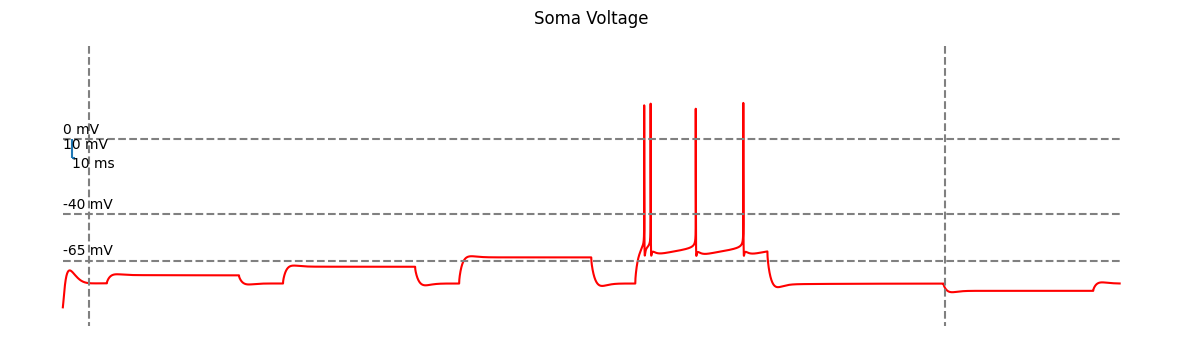

In [23]:
plt.figure(figsize=(15,4))
plt.plot(np.arange(0,((h.tstop)+.1),.1),v_dend,color='r')
plt.hlines(-65,0,tstop, color = 'grey', linestyle = 'dashed')
plt.hlines(-40,0,tstop, color = 'grey', linestyle = 'dashed')
plt.hlines(0,0,tstop, color = 'grey', linestyle = 'dashed')
plt.vlines(150,50,-100, color = 'grey', linestyle = 'dashed')
plt.vlines(i/10,50,-100, color = 'grey', linestyle = 'dashed')
plt.text(2,3,'0 mV')
plt.hlines(-10,50,70)
plt.vlines(50,-10,0)
plt.text(50,-15,'10 ms')
plt.text(2,-5,'10 mV')
plt.text(2,-37,'-40 mV')
plt.text(2,-62,'-65 mV')
plt.title('Soma Voltage')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [29]:
input_resistance_error=complex_cell_input_resistance_inMOhms-reduced_cell_input_resistance_inMOhms
tau_error=complex_cell_tau_in_ms-reduced_cell_tau_in_ms

input_resistance_relative_error=input_resistance_error/complex_cell_input_resistance_inMOhms
tau_relative_error=tau_error/complex_cell_tau_in_ms

print('Complex Cell Input Resistance: ',complex_cell_input_resistance_inMOhms, 'MOhms')
print('Reduced Cell Input Resistance: ',reduced_cell_input_resistance_inMOhms, 'MOhms')
print()
print('Complex Cell Time Constant: ',complex_cell_tau_in_ms, '(ms)')
print('Reduced Cell Time Constant: ',reduced_cell_tau_in_ms, '(ms)')
print()
print('Cell Input Resistance Error due to Model Reduction: ',input_resistance_error, 'MOhms')
print('Cell Time Constant Error due to Model Reduction: ',tau_error, '(ms)')
print()
print('Cell Input Resistance Relative Error due to Model Reduction: ',input_resistance_relative_error*100, '%')
print('Cell Time Constant Relative Error due to Model Reduction: ',tau_relative_error*100, '%')


Complex Cell Input Resistance:  38.3885319673864 MOhms
Reduced Cell Input Resistance:  42.11169001277284 MOhms

Complex Cell Time Constant:  9.5 (ms)
Reduced Cell Time Constant:  9.400000000000546 (ms)

Cell Input Resistance Error due to Model Reduction:  -3.723158045386441 MOhms
Cell Time Constant Error due to Model Reduction:  0.0999999999994543 (ms)

Cell Input Resistance Relative Error due to Model Reduction:  -9.698620537376918 %
Cell Time Constant Relative Error due to Model Reduction:  1.0526315789416243 %


In [38]:
print(np.array(cell.spikes)[cell.spikes<3000])

[[2344.6        3278.         3300.7        3349.7        3496.5
  3659.3        3816.60000001 3972.50000001]]


In [36]:
np.where(spikes<3000)

TypeError: ignored

In [27]:
for i in range(len(cell.spikes)):
  print(cell.spikes[i])


2344.599999999864
3278.0000000032596
3300.700000003342
3349.7000000035205
3496.5000000040545
3659.300000004647
3816.600000005219
3972.500000005786


8


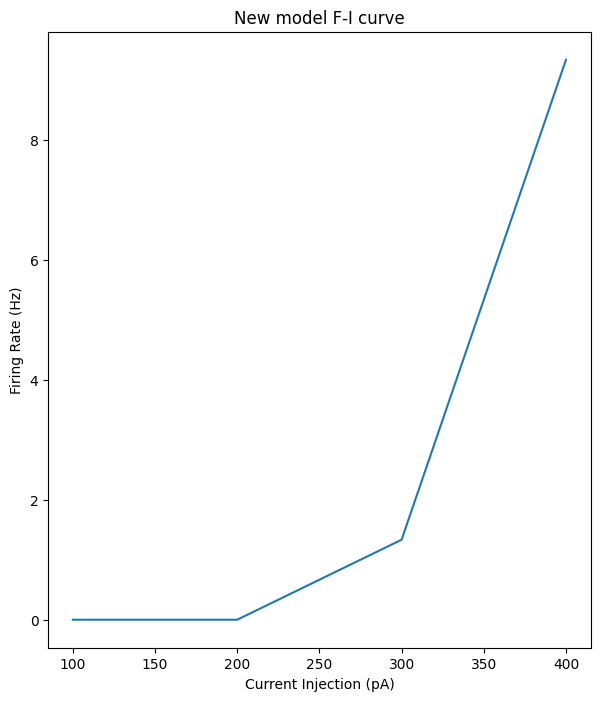

In [37]:
# possible implementation for plotting F/I Curve
spikes = np.array(cell.spikes)

print(len(spikes))

HzAt100Pa = len(spikes[spikes < 1000])*1.3333
HzAt200Pa = len(spikes[(spikes > 1000) & (spikes < 2000)])*1.3333
HzAt300Pa = len(spikes[(spikes > 2000) & (spikes < 3000)])*1.3333
HzAt400Pa = len(spikes[spikes > 3000])*1.3333




pA = [100,200,300,400]
Hz = [HzAt100Pa,HzAt200Pa,HzAt300Pa,HzAt400Pa]


plt.figure(figsize=(7,8))
ax = plt.plot(pA,Hz)
plt.title('New model F-I curve')
plt.xlabel('Current Injection (pA)')
plt.ylabel('Firing Rate (Hz)')
plt.savefig('FI_curve.png')
plt.show()

4


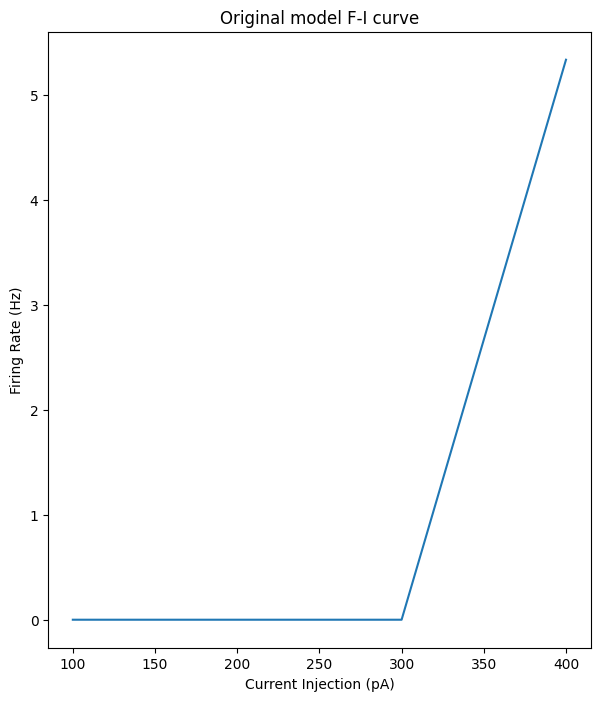

In [40]:
# possible implementation for plotting F/I Curve
spikes = np.array(original_model.spikes)

print(len(spikes))

HzAt100Pa = len(spikes[spikes < 1000])*1.3333
HzAt200Pa = len(spikes[(spikes > 1000) & (spikes < 2000)])*1.3333
HzAt300Pa = len(spikes[(spikes > 2000) & (spikes < 3000)])*1.3333
HzAt400Pa = len(spikes[spikes > 3000])*1.3333




pA = [100,200,300,400]
Hz = [HzAt100Pa,HzAt200Pa,HzAt300Pa,HzAt400Pa]


plt.figure(figsize=(7,8))
ax = plt.plot(pA,Hz)
plt.title('Original model F-I curve')
plt.xlabel('Current Injection (pA)')
plt.ylabel('Firing Rate (Hz)')
plt.savefig('FI_curve.png')
plt.show()